In [55]:
!pip install xgboost
!pip install lightgbm
!pip install imblearn

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
warnings.filterwarnings('ignore')

In [57]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df=pd.read_csv('sample_submission.csv')

In [58]:
print(f"✅ Train Data Shape: {train_df.shape}")
print(f"✅ Test Data Shape: {test_df.shape}")
print(submission_df.shape)

✅ Train Data Shape: (90000, 126)
✅ Test Data Shape: (10000, 125)
(10000, 2)


In [59]:
missing_count = train_df.isnull().sum().sum()
print(f"Missing values in train before handling: {missing_count}")
# -------------------------------
# Check Missing Values per Column
# -------------------------------
print("\n\nMissing Values per Column:")
missing_values = train_df.isnull().sum()
print(missing_values, end="\n\n")

Missing values in train before handling: 1993296


Missing Values per Column:
TransactionID         0
FraudLabel            0
ProductCategory       0
CardSecurityCode    235
CardType            235
                   ... 
V304                  2
V312                  2
V313                213
V314                213
V315                213
Length: 126, dtype: int64



In [60]:
missing_count = test_df.isnull().sum().sum()
print(f"Missing values in test before handling: {missing_count}")
# -------------------------------
# Check Missing Values per Column
# -------------------------------
print("\n\nMissing Values per Column:")
missing_values = test_df.isnull().sum()
print(missing_values, end="\n\n")

Missing values in test before handling: 246066


Missing Values per Column:
TransactionID        0
ProductCategory      0
CardSecurityCode    24
CardType            25
CardUsageType       24
                    ..
V304                 1
V312                 1
V313                15
V314                15
V315                15
Length: 125, dtype: int64



In [61]:
# Check class distribution in the target variable (FraudLabel)
train_df['FraudLabel'].value_counts(normalize=True)

,proportion
FraudLabel,
0,0.85
1,0.15


In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Columns: 126 entries, TransactionID to V315
dtypes: float64(111), int64(2), object(13)
memory usage: 86.5+ MB


In [63]:
train_df.head()

,TransactionID,FraudLabel,ProductCategory,CardSecurityCode,CardType,CardUsageType,PrimaryEmailDomain,D1,D2,D3,...,V283,V289,V290,V302,V303,V304,V312,V313,V314,V315
0,3324111,0,W,150.0,visa,debit,yahoo.com,47.0,47.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,117.0,0.0,112.0,0.0
1,3030057,1,R,150.0,visa,debit,gmail.com,0.0,NaN,NaN,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,3387080,0,W,150.0,mastercard,credit,gmail.com,0.0,NaN,NaN,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3441177,0,W,150.0,mastercard,debit,yahoo.com,12.0,12.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,117.0,117.0,234.0,117.0
4,3397229,0,W,150.0,mastercard,credit,gmail.com,136.0,136.0,75.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
train_df = train_df.drop(columns=[col for col in train_df.columns if col.startswith('D') or col.startswith('V')  or col.startswith('M')])
test_df = test_df.drop(columns=[col for col in test_df.columns if col.startswith('D') or col.startswith('V') or col.startswith('M')])

print(f"✅ Train shape after dropping columns: {train_df.shape}")
print(f"✅ Test shape after dropping columns: {test_df.shape}")

✅ Train shape after dropping columns: (90000, 7)
✅ Test shape after dropping columns: (10000, 6)


In [65]:
train_df.head()

,TransactionID,FraudLabel,ProductCategory,CardSecurityCode,CardType,CardUsageType,PrimaryEmailDomain
0,3324111,0,W,150.0,visa,debit,yahoo.com
1,3030057,1,R,150.0,visa,debit,gmail.com
2,3387080,0,W,150.0,mastercard,credit,gmail.com
3,3441177,0,W,150.0,mastercard,debit,yahoo.com
4,3397229,0,W,150.0,mastercard,credit,gmail.com


In [66]:
train_df['CardSecurityCode'] = train_df['CardSecurityCode'].fillna(train_df['CardSecurityCode'].mean())
test_df['CardSecurityCode'] = test_df['CardSecurityCode'].fillna(test_df['CardSecurityCode'].mean())

for col in ['ProductCategory','CardType', 'CardUsageType','PrimaryEmailDomain']:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [67]:
train_df.isna().sum()

,0
TransactionID,0
FraudLabel,0
ProductCategory,0
CardSecurityCode,0
CardType,0
CardUsageType,0
PrimaryEmailDomain,0


In [68]:
print(train_df['CardType'].value_counts())
print(train_df['CardUsageType'].value_counts())
#print(train_df['PrimaryEmailDomain'].value_counts())
print()
print('test')
print(test_df['CardType'].value_counts())
print(test_df['CardUsageType'].value_counts())
#print(train_df['PrimaryEmailDomain'].value_counts())

CardType
visa                58814
mastercard          28742
american express     1257
discover             1187
Name: count, dtype: int64
CardUsageType
debit              64685
credit             25309
charge card            4
debit or credit        2
Name: count, dtype: int64

test
CardType
visa                6508
mastercard          3191
discover             168
american express     133
Name: count, dtype: int64
CardUsageType
debit     6352
credit    3648
Name: count, dtype: int64


In [69]:
for col in train_df.select_dtypes(include=['object']):
    print(f"Unique values for {col}: {train_df[col].unique()}")

Unique values for ProductCategory: ['W' 'R' 'H' 'C' 'S']
Unique values for CardType: ['visa' 'mastercard' 'american express' 'discover']
Unique values for CardUsageType: ['debit' 'credit' 'charge card' 'debit or credit']
Unique values for PrimaryEmailDomain: ['yahoo.com' 'gmail.com' 'aol.com' 'hotmail.com' 'anonymous.com'
 'icloud.com' 'comcast.net' 'sbcglobal.net' 'rocketmail.com' 'live.com'
 'yahoo.com.mx' 'outlook.com' 'ymail.com' 'suddenlink.net' 'mac.com'
 'yahoo.es' 'me.com' 'msn.com' 'bellsouth.net' 'verizon.net' 'att.net'
 'windstream.net' 'twc.com' 'cox.net' 'cfl.rr.com' 'sc.rr.com'
 'charter.net' 'outlook.es' 'optonline.net' 'live.com.mx'
 'frontiernet.net' 'mail.com' 'hotmail.fr' 'web.de' 'embarqmail.com'
 'juno.com' 'frontier.com' 'earthlink.net' 'roadrunner.com' 'aim.com'
 'q.com' 'yahoo.fr' 'centurylink.net' 'netzero.com' 'netzero.net' 'gmail'
 'yahoo.co.jp' 'hotmail.es' 'yahoo.co.uk' 'prodigy.net.mx'
 'protonmail.com' 'hotmail.de' 'ptd.net' 'hotmail.co.uk' 'gmx.de'
 'cab

In [70]:
train_df = train_df[~train_df['CardUsageType'].isin(['charge card', 'debit or credit'])]
test_df = test_df[~test_df['CardUsageType'].isin(['Charge Card', 'debit or credit'])]

print(f"✅ Train shape after dropping card types: {train_df.shape}")
print(f"✅ Test shape after dropping card types: {test_df.shape}")


✅ Train shape after dropping card types: (89994, 7)
✅ Test shape after dropping card types: (10000, 6)


In [71]:
train_df.isna().sum()

,0
TransactionID,0
FraudLabel,0
ProductCategory,0
CardSecurityCode,0
CardType,0
CardUsageType,0
PrimaryEmailDomain,0


In [72]:
test_df.columns

Index(['TransactionID', 'ProductCategory', 'CardSecurityCode', 'CardType',
       'CardUsageType', 'PrimaryEmailDomain'],
      dtype='object')

In [73]:
email_domain_counts = train_df['PrimaryEmailDomain'].value_counts(normalize=True)
train_df['PrimaryEmailDomain_freq'] = train_df['PrimaryEmailDomain'].map(email_domain_counts)
test_df['PrimaryEmailDomain_freq'] = test_df['PrimaryEmailDomain'].map(email_domain_counts)

In [74]:
train_df.head()

,TransactionID,FraudLabel,ProductCategory,CardSecurityCode,CardType,CardUsageType,PrimaryEmailDomain,PrimaryEmailDomain_freq
0,3324111,0,W,150.0,visa,debit,yahoo.com,0.164044
1,3030057,1,R,150.0,visa,debit,gmail.com,0.554904
2,3387080,0,W,150.0,mastercard,credit,gmail.com,0.554904
3,3441177,0,W,150.0,mastercard,debit,yahoo.com,0.164044
4,3397229,0,W,150.0,mastercard,credit,gmail.com,0.554904


In [75]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_array = encoder.fit_transform(train_df[['ProductCategory', 'CardType', 'CardUsageType']])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['ProductCategory', 'CardType', 'CardUsageType']))
train_df = pd.concat([train_df.drop(['ProductCategory', 'CardType', 'CardUsageType'], axis=1), encoded_df], axis=1)

testencode=encoder.fit_transform(test_df[['ProductCategory', 'CardType', 'CardUsageType']])
testencode_df = pd.DataFrame(testencode, columns=encoder.get_feature_names_out(['ProductCategory', 'CardType', 'CardUsageType']))
test_df = pd.concat([test_df.drop(['ProductCategory', 'CardType', 'CardUsageType'], axis=1), testencode_df], axis=1)

In [76]:
train_df.head()

,TransactionID,FraudLabel,CardSecurityCode,PrimaryEmailDomain,PrimaryEmailDomain_freq,ProductCategory_H,ProductCategory_R,ProductCategory_S,ProductCategory_W,CardType_discover,CardType_mastercard,CardType_visa,CardUsageType_debit
0,3324111.0,0.0,150.0,yahoo.com,0.164044,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,3030057.0,1.0,150.0,gmail.com,0.554904,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3387080.0,0.0,150.0,gmail.com,0.554904,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3441177.0,0.0,150.0,yahoo.com,0.164044,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,3397229.0,0.0,150.0,gmail.com,0.554904,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [77]:
cols=['TransactionID','PrimaryEmailDomain']
train_df=train_df.drop(columns=cols)
test_df=test_df.drop(columns=cols)

In [78]:
scaler = StandardScaler()
train_df['CardSecurityCode'] = scaler.fit_transform(train_df[['CardSecurityCode']])
test_df['CardSecurityCode'] = scaler.transform(test_df[['CardSecurityCode']])

xtrain=train_df.drop(columns=['FraudLabel'])
ytrain=train_df['FraudLabel']

In [82]:
xtrain.head()

,CardSecurityCode,PrimaryEmailDomain_freq,ProductCategory_H,ProductCategory_R,ProductCategory_S,ProductCategory_W,CardType_discover,CardType_mastercard,CardType_visa,CardUsageType_debit
0,-0.340533,0.164044,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,-0.340533,0.554904,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,-0.340533,0.554904,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.340533,0.164044,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,-0.340533,0.554904,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [80]:
print(train_df.columns)
print(test_df.columns)

Index(['FraudLabel', 'CardSecurityCode', 'PrimaryEmailDomain_freq',
       'ProductCategory_H', 'ProductCategory_R', 'ProductCategory_S',
       'ProductCategory_W', 'CardType_discover', 'CardType_mastercard',
       'CardType_visa', 'CardUsageType_debit'],
      dtype='object')
Index(['CardSecurityCode', 'PrimaryEmailDomain_freq', 'ProductCategory_H',
       'ProductCategory_R', 'ProductCategory_S', 'ProductCategory_W',
       'CardType_discover', 'CardType_mastercard', 'CardType_visa',
       'CardUsageType_debit'],
      dtype='object')


In [89]:
# prompt: perform smote on xtrain and ytrain
smote = SMOTE(random_state=42)
xtrain, ytrain = smote.fit_resample(xtrain, ytrain)

In [94]:
print(ytrain.value_counts())  # Check class distribution in train set
print(y_test.value_counts())   # Check class distribution in test set

FraudLabel
0.0    76494
1.0    76494
Name: count, dtype: int64
FraudLabel
0    10000
Name: count, dtype: int64


FraudLabel
0.0    76494
1.0    76494
Name: count, dtype: int64


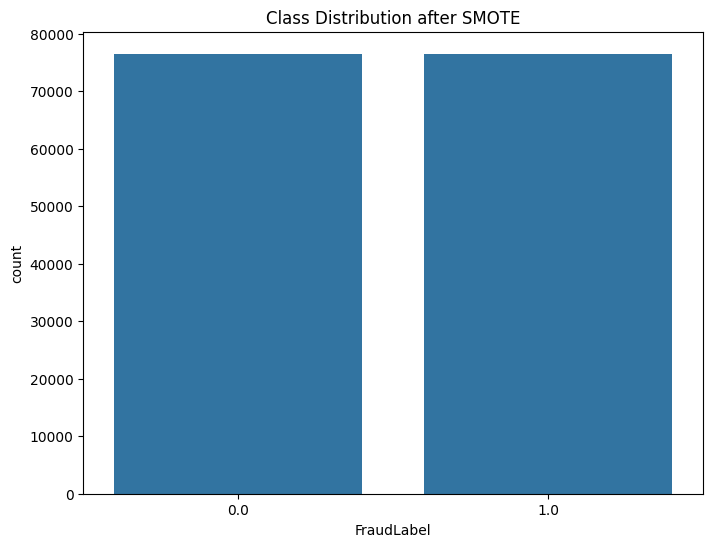

In [90]:
# prompt: see class distribution
print(ytrain.value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(x=ytrain)
plt.title('Class Distribution after SMOTE')
plt.show()


In [91]:
models={
    'LogisticRegression':LogisticRegression(),
    'XGBClassifier':XGBClassifier(),
    'LGBMClassifier':LGBMClassifier()
}

In [92]:
y_test=submission_df['FraudLabel']
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(xtrain, ytrain)
    y_pred = model.predict(test_df)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"{name} - F1 Score: {f1:.4f}, ROC AUC Score: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("-" * 30)

Training LogisticRegression...
LogisticRegression - F1 Score: 0.0000, ROC AUC Score: nan
              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87     10000
         1.0       0.00      0.00      0.00         0

    accuracy                           0.77     10000
   macro avg       0.50      0.38      0.43     10000
weighted avg       1.00      0.77      0.87     10000

[[7658 2342]
 [   0    0]]
------------------------------
Training XGBClassifier...
XGBClassifier - F1 Score: 0.0000, ROC AUC Score: nan
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     10000
           1       0.00      0.00      0.00         0

    accuracy                           0.76     10000
   macro avg       0.50      0.38      0.43     10000
weighted avg       1.00      0.76      0.86     10000

[[7608 2392]
 [   0    0]]
------------------------------
Training LGBMClassifier...
[LightGBM] [Info] Number of positiv